# Project 3 for CSE142
## CIFAR-10 Classification

Importing necessary packages:

- tensorflow/keras: API to build and train models
- matplotlib: generate graphs
- numpy: perform array operations
- pandas: to work with dataframes
- pickle: for serializing and de-serializing a Python object
- os: for file paths

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import pandas as pd
# import pickle
# import os, os.path

### *Initialize relevant variables*

In [2]:
labels_df = pd.read_csv("Semi1_Labels.csv") #change this for different versions
train_path = 'Train_Image' 
test_path = 'Test_Image' 
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels_df

,Train Label
0,NAN
1,dog
2,NAN
3,airplane
4,NAN
...,...
9995,NAN
9996,NAN
9997,airplane
9998,NAN


## Defining some functions

In [3]:
def get_image(img_number):
    img = mpimg.imread(train_path + f"/{img_number}.png") 
    return img
def get_test_image(img_number):
    img = mpimg.imread(test_path + f"/{img_number}.png") 
    return img

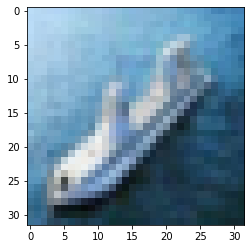

In [4]:
plt.imshow(get_image(7777))

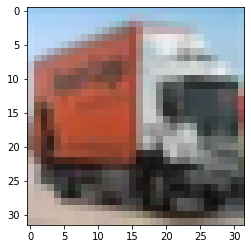

In [5]:
plt.imshow(get_test_image(999))

**Function that prints image info**

In [6]:
def get_img_info(img):
    rows,cols,channels = img.shape 
    img_size = rows*cols*channels # channels means rgb colors i think, so should always be 3?
    img_to_1D = img.reshape(img_size) #numPy reshape
    print("rows, cols, channels:", rows, cols, channels)
    print("image size:", img_size)
#     print("image original:", img)
#     print("image reshape:", img_to_1D)
#     return img_to_1D

In [7]:
get_img_info(get_image(3)) 

rows, cols, channels: 32 32 3
image size: 3072


## Preprocessing the  Data

We need to separate the labeled data from the unlabeled

Also need to encode labels as numbers instead of strings

In [8]:
#is_unlabelled = labels_df["Train Label"] == NAN
labelled = (labels_df["Train Label"]!= "NAN")
unlabelled = (labels_df["Train Label"] == "NAN")

unlabelled_data = (labels_df[unlabelled])
print(unlabelled_data)

labelled_data = (labels_df[labelled])
print(labelled_data)

     Train Label
0            NAN
2            NAN
4            NAN
5            NAN
6            NAN
...          ...
9994         NAN
9995         NAN
9996         NAN
9998         NAN
9999         NAN

[8000 rows x 1 columns]
     Train Label
1            dog
3       airplane
8           deer
18          frog
26          deer
...          ...
9977        deer
9988        frog
9990  automobile
9992        bird
9997    airplane

[2000 rows x 1 columns]


In [9]:
labeled = []
unlabeled = []

labeled = labelled_data["Train Label"].tolist()
unlabeled = unlabelled_data["Train Label"].tolist()

print (labeled) 
print (unlabeled) 

['dog', 'airplane', 'deer', 'frog', 'deer', 'dog', 'cat', 'airplane', 'bird', 'automobile', 'cat', 'automobile', 'dog', 'ship', 'cat', 'deer', 'cat', 'deer', 'bird', 'frog', 'frog', 'horse', 'frog', 'frog', 'ship', 'cat', 'truck', 'bird', 'bird', 'horse', 'deer', 'dog', 'cat', 'horse', 'airplane', 'dog', 'truck', 'airplane', 'cat', 'frog', 'ship', 'horse', 'horse', 'truck', 'truck', 'airplane', 'truck', 'truck', 'cat', 'horse', 'frog', 'frog', 'deer', 'automobile', 'dog', 'dog', 'cat', 'horse', 'frog', 'automobile', 'deer', 'ship', 'dog', 'bird', 'airplane', 'horse', 'airplane', 'cat', 'airplane', 'automobile', 'deer', 'frog', 'ship', 'frog', 'ship', 'dog', 'horse', 'dog', 'horse', 'bird', 'airplane', 'dog', 'frog', 'automobile', 'automobile', 'truck', 'ship', 'frog', 'horse', 'frog', 'ship', 'deer', 'automobile', 'frog', 'automobile', 'deer', 'horse', 'cat', 'truck', 'horse', 'cat', 'automobile', 'bird', 'truck', 'truck', 'automobile', 'bird', 'airplane', 'automobile', 'frog', 'horse'

In [10]:
#col = labels_df.columns
#for i, entry in enumerate(labels_df[col[0]]):
 #   if (entry == 'NAN'):
  #      unlabeled.append(i)
   # else:
   #     labeled.append([i, entry])
# print("labeled", labeled)
# print("unlabeled", unlabeled)


2000


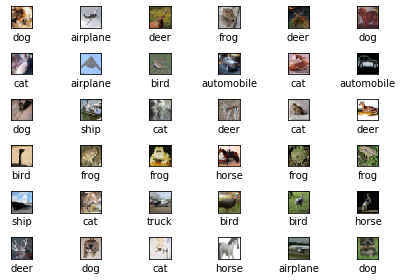

In [11]:
# Need to reshape training data and labels
train_images, train_labels, test_images, test_labels = [], [], [], []
for i in labelled_data.iterrows():
    train_images.append(get_image(i[0]))
    train_labels.append(i[1]['Train Label'])
print(len(train_images))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

In [12]:
#encoding labels
for i in range(len(train_labels)):
    for j in range(len(labels)):
        if train_labels[i] == labels[j]:
            train_labels[i] = j
print (train_labels[1])

0


In [13]:
#split labeled data so that we have some labeled testing data 80/20
test_images =  np.array(train_images[1600:])
train_images = np.array(train_images[:1600])
test_labels = np.array(train_labels[1600:])
train_labels = np.array(train_labels[:1600])
print(len(train_images), len(train_labels), len(test_images), len(test_labels))


1600 1600 400 400


## Baseline Model

### Convolutional Neural Network

As input, a CNN takes tensors of shape (height, width, channels) = (32, 32, 3)

This is based on https://www.tensorflow.org/tutorials/images/cnn

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(test_images, test_labels))

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 2s 1ms/sample - loss: 2.2498 - accuracy: 0.1581 - val_loss: 2.1436 - val_accuracy: 0.2275
Epoch 2/20
1600/1600 [==============================] - 1s 638us/sample - loss: 2.0295 - accuracy: 0.2644 - val_loss: 1.9164 - val_accuracy: 0.2650
Epoch 3/20
1600/1600 [==============================] - 1s 639us/sample - loss: 1.8710 - accuracy: 0.3250 - val_loss: 1.9660 - val_accuracy: 0.3200
Epoch 4/20
1600/1600 [==============================] - 1s 638us/sample - loss: 1.7742 - accuracy: 0.3556 - val_loss: 1.8900 - val_accuracy: 0.3150
Epoch 5/20
1600/1600 [==============================] - 1s 635us/sample - loss: 1.7338 - accuracy: 0.3675 - val_loss: 1.8294 - val_accuracy: 0.3425
Epoch 6/20
1600/1600 [==============================] - 1s 638us/sample - loss: 1.6209 - accuracy: 0.4231 - val_loss: 1.7001 - val_accuracy: 0.3975
Epoch 7/20
1600/1600 [==============================] - 1s 633us/sa

## Augmenting the Model



**Predicting on the test images** 

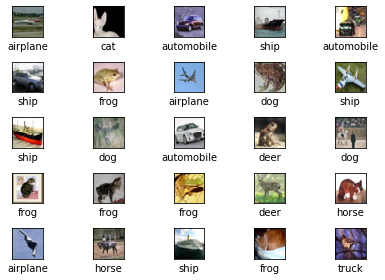

In [42]:
test_image = []
for i in range(25):
    test_image.append(get_test_image(i))
    
predictions = model.predict(np.array(test_image))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(get_test_image(i))
    plt.xlabel(get_label(predictions[i]))
plt.show()